In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.append(parent_dir)

# Regular Imports
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
from tqdm import tqdm

import inference.scheduler
from inference.distribution import Gaussian, GaussianMixture, InterpolatedDensity
from inference.sde import EulerMaruyamaSimulator, LangevinDynamics
import utils.vis2d.visualization

# Visualizations

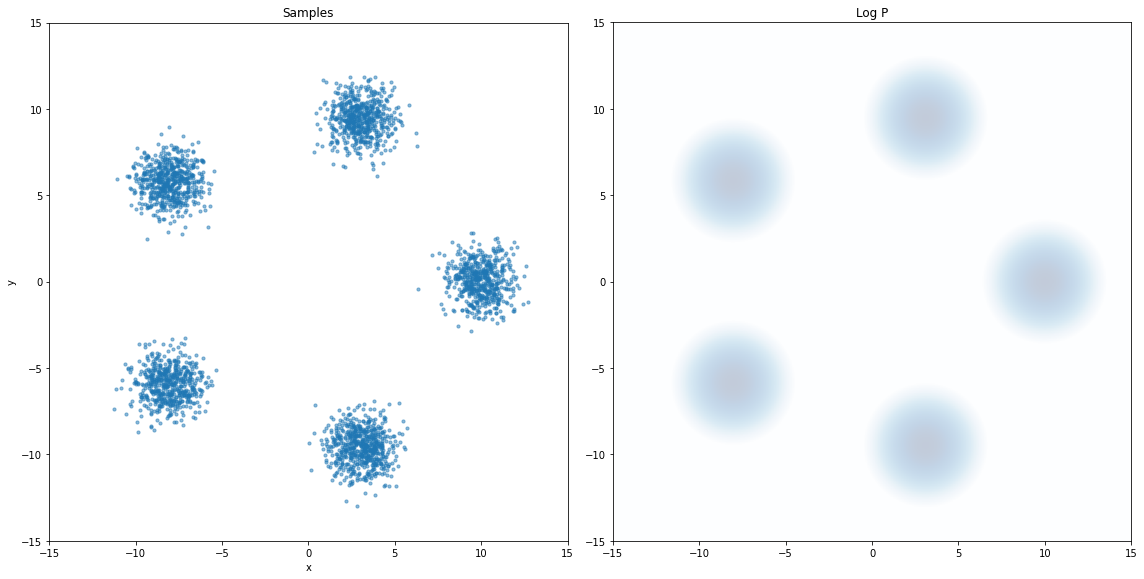

In [4]:
### Distribution
PARAMS = {
    "scale": 15.0,
    "target_scale": 10.0,
    "target_std": 1.0,
}
dist = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device)


### Visualization
scale = PARAMS["scale"]
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]

fig, axes = plt.subplots(1,2, figsize=(16,8))

# Left plot
num_samples = 3000
samples = dist.sample(num_samples=num_samples)

axes[0].set_title('Samples')
utils.vis2d.visualization.visualize_samples(samples, 
                                            x_bounds=x_bounds, 
                                            y_bounds=y_bounds, 
                                            ax=axes[0])

# Right plot
axes[1].set_title('Log P')
im = utils.vis2d.visualization.visualize_density(density=dist, 
                                                 x_bounds=x_bounds, 
                                                 y_bounds=y_bounds, 
                                                 bins=200, 
                                                 device=device,
                                                 ax=axes[1], vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))
fig.tight_layout()
plt.show()

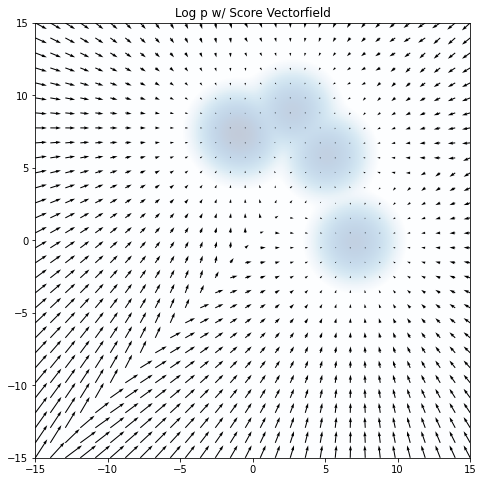

In [5]:
seed = torch.randint(low=0, high=1000, size=(1,))
dist = GaussianMixture.random_2D(nmodes=5, 
                                 std=1.0, 
                                 scale=20.0, 
                                 seed=seed)

fig, ax = plt.subplots(1,1, figsize=(8,8))
utils.vis2d.visualization.visualize_score_vectorfield(density=dist, 
                            x_bounds=x_bounds, 
                            y_bounds=y_bounds, 
                            num_arrows=30, 
                            bins=200,
                            device=device,
                            ax=ax,
                            vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))
plt.title('Log p w/ Score Vectorfield')
plt.show()

# Annealed Interpolated Scores

You are given the target score $s_1(x)$, and want to sample from its corresponding distirtribution.

The idea is to start at an easy to sample base distribution (with score $s_0(x)$), and then graduallly interpolate to the target score.
$$
s_t(x) = (1- \lambda(t)) s_0(x) + \lambda(t) s_1(x)
$$
where $\lambda(0) = 0$ and $\lambda(1) = 1$.

### Procedure
Require: (1) A set of samples $\{x_{i,0}\}_i$ sampled from the distribution corresponding to $s_0(x)$, and (2) a target score $s_1(x)$.

- For $t$ in `torch.linspace(0, 1, N)`:
    - Set interpolated score: $s_t(x) = (1 - \lambda(t))  s_0(x) + \lambda(t) s_1(x)$
    - Use langevin dynamics to transport samples $\{x_{i, t-1} \} \to \{x_{i, t}\}$, using score $s_t(x)$

In [6]:
class LinearInterpolatedDensity(InterpolatedDensity):

    def __init__(self, density0, density1):
        super().__init__(density0, density1)
    
    def interpolate(self, log_density0: torch.Tensor, log_density1: torch.Tensor, alpha: float) -> torch.Tensor:
        """
        Constructs interpolation between density0 and density1
        Args:
            - log_density0 (torch.Tensor): Log density of density0 evaluated at x
            - log_density1 (torch.Tensor): Log density of density1 evaluated at x
            - alpha (float): Interpolation parameter (0 <= alpha <= 1)
        """
        return log_density0 + alpha * (log_density1 - log_density0)

In [7]:
import torch
import matplotlib.pyplot as plt

from inference.distribution import InterpolatedDensity
from inference.simulator import Simulator

def run(dist: InterpolatedDensity, 
        x: torch.Tensor, 
        ts: torch.Tensor,
        noise_scheduler: inference.scheduler.Scheduler,
        interpolant_steps: torch.Tensor) -> torch.Tensor:    
    # Run Simulation
    xs = [x.clone()] 
    for step_pct in tqdm(interpolant_steps):
        score = lambda x, _: dist.score(x, alpha=step_pct)
        sde = LangevinDynamics(score=score, 
                               noise_scheduler=noise_scheduler)
        simulator = EulerMaruyamaSimulator(sde=sde)
        x = simulator.simulate(x=x, ts=ts) # shape (batch_size, dim)
        xs.append(x.clone())
    return torch.stack(xs, dim=1) # Shape (batch_size, interpolant_steps, dim)

def plot_trajectories_2d(x0: torch.Tensor,  
                         timesteps: torch.Tensor,
                         density: InterpolatedDensity,
                         noise_scheduler: inference.scheduler.Scheduler,
                         interpolant_steps: torch.Tensor,
                         x_bounds,
                         y_bounds,
                         show_num_steps: int = 5,):
    # Simulate Trajectories
    trajectories = run(dist=density, 
                       x=x0, 
                       ts=timesteps, 
                       noise_scheduler=noise_scheduler,
                       interpolant_steps=interpolant_steps) # Shape (batch_size, num_timesteps, dim)

    # Find slices to plot
    indices = torch.linspace(0, len(interpolant_steps)-1, show_num_steps, dtype=int)

    # Plot
    fig, axes = plt.subplots(nrows=1, ncols=show_num_steps, figsize=(30, 30))
    for i, ax in enumerate(axes):
        index = indices[i]
        t = interpolant_steps[index]
        
        # Subplot settings
        ax.set_title(f"t = {t:.2f}")
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        
        # Plot Current position of samples
        x = trajectories[:, index, 0]
        y = trajectories[:, index, 1]
        ax.scatter(x=x, y=y, alpha=0.9, s=10.0)

        # Plot Density
        logprob = lambda x: density.log_density(x, alpha=t)
        utils.vis2d.visualization.visualize_scalarfield(scalarfield=logprob, 
                                                        x_bounds=x_bounds, 
                                                        y_bounds=y_bounds, 
                                                        bins=200, 
                                                        device=device,
                                                        ax=ax, vmin=-15, alpha=0.75, cmap=plt.get_cmap('Reds'))
        
        # Plot Vector Field
        score = lambda x: density.score(x, alpha=t)
        utils.vis2d.visualization.visualize_vectorfield(vectorfield=score,
                                                        x_bounds=x_bounds,
                                                        y_bounds=y_bounds,
                                                        num_arrows=20,
                                                        ax=ax)
    return fig, axes



100%|██████████| 13/13 [00:43<00:00,  3.38s/it]


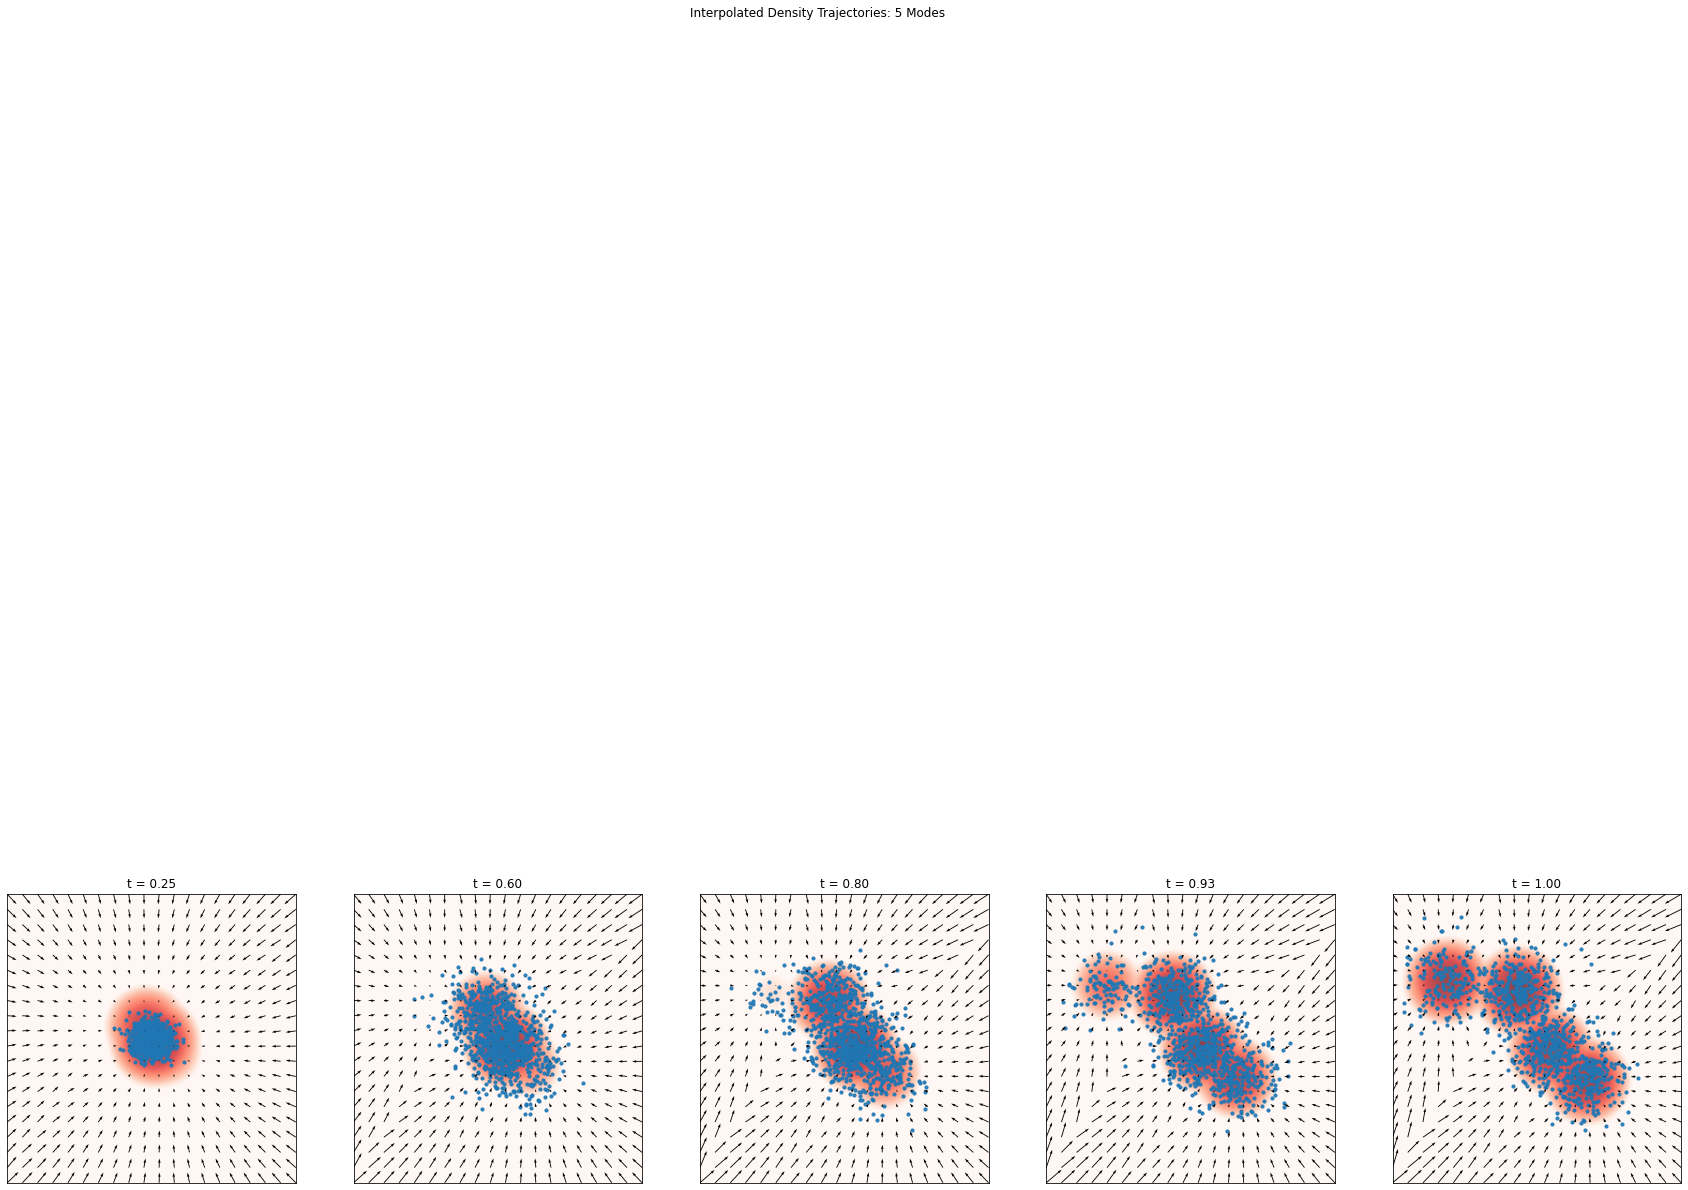

In [8]:
### Setup
# Distribution Setup
nmodes = 5
std = 1.0
scale = 20.0
seed = 1

density0 = Gaussian(mean=torch.zeros(2), cov=torch.eye(2))
density1 = GaussianMixture.random_2D(nmodes=nmodes, 
                                     std=std, 
                                     scale=scale, 
                                     seed=seed)

# Simulator setup
noise_scheduler = inference.scheduler.Linear(3.0, 0.5)
x0 = density0.sample(num_samples=1000)
interpolant_steps = torch.tensor([0.25, 0.35, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.925, 0.955, 0.975, 1.0])
num_steps, step_size = 1000, 0.01
ts = torch.arange(0, num_steps * step_size, step_size)

# Training Setup



### Code
# Setup up
dist_interpolated = LinearInterpolatedDensity(density0=density0, density1=density1) # Interpolated density

fig, axes = plot_trajectories_2d(x0=x0, 
                                 timesteps=ts, 
                                 density=dist_interpolated,
                                 noise_scheduler=noise_scheduler,
                                 interpolant_steps=interpolant_steps,
                                 x_bounds=[-scale * 0.75, scale * 0.75],
                                 y_bounds=[-scale * 0.75, scale * 0.75],)
fig.suptitle(f"Interpolated Density Trajectories: {nmodes} Modes")
plt.show()

Legend:
- Red blobs: True distribution
- Blue dots: Transported samples
- Black lines: Score

It has worked well for `seed`s: `[42, 54]`
- 42
- 54